In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
import torch 
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

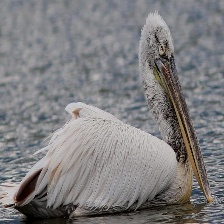

In [16]:
# Daten Vorbereitung
from PIL import Image
image_path = '/kaggle/input/100-bird-species/train/DALMATIAN PELICAN/001.jpg'
image = Image.open(image_path)
image

In [ ]:
from tqdm import tqdm 

mean = 0.0
for images, _ in tqdm(train_loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_loader.dataset)
mean

In [ ]:
var = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / len(train_loader.dataset)*150*150)
std

In [61]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
}

In [62]:
train_dataset = datasets.ImageFolder(root="/kaggle/input/100-bird-species/train", transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root="/kaggle/input/100-bird-species/valid", transform=data_transforms['valid'])

In [63]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=True)

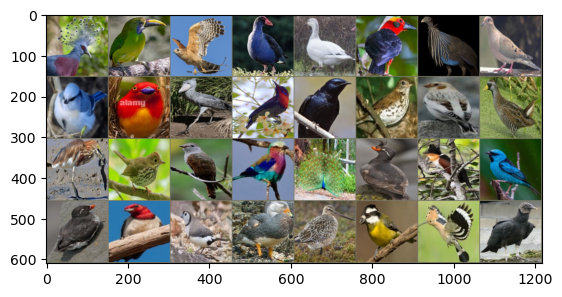

In [66]:
# Daten Exploration

def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4740, 0.4693, 0.3957])
    std = np.array([5275.1636, 5137.1646, 5632.8296])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

inputs, classes = next(iter(train_loader))
out = utils.make_grid(inputs)
imshow(out)

tensor([0.4740, 0.4693, 0.3957])

tensor([5275.1636, 5137.1646, 5632.8296])

In [74]:
# Convolutional Neural Network (CNN) Architektur
 
class BirdNet(nn.Module):
    def __init__(self, num_classes=525):
        super(BirdNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #150 -> 75
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) #75 -> 37 (37.5)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #37 -> 18 (18.5)
        self.pool =  nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 18 * 18, 512) #fully connected layer
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*18*18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BirdNet()

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [ ]:
# Modeltraining

num_epochs = 10

train_losses = [] 
valid = []

for epoch in range(num_epochs):
    #training phase
    model.train()
    
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, loader = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #reset gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #backprop
        
        optimizer.step() #update weights
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    #val phase
    model.eval() #eval mode
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, loader = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    valid_loss = running_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} => "
          f"Train loss: {train_loss:.4f}, "
          f"Validation loss: {valid_loss:.4f}, "
          f"Validation accuracy: {avid_accuracy:.4f}"
         )
    